In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [2]:
import geomloss
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import scipy.stats as st
import seaborn
import torch

In [82]:
def systematic_resample(weights, randomState):
    N = len(weights)

    positions = (randomState.random() + np.arange(N)) / N

    indexes = np.zeros(N, dtype = int)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes


In [83]:
cpu = torch.device('cpu')

$X \sim \sum_i w_i, \delta_{X_i}$ where the $X_i$'s are i.i.d. $U([-2, 2])$ and $w_i \propto f(X_i)$ where $f$ is the pdf of a normal distribution $ \mathcal{N}(1, 1)$

In [84]:
randomState = np.random.RandomState(42)
N = 500

In [121]:
X = randomState.uniform(-2, 2, (N,) )

loc=0.5
scale=0.25
weights = st.norm.pdf(X, loc=-0.5, scale=0.25)
random_index = randomState.choice(N, 250, False)
weights[random_index] = st.norm.pdf(X[random_index], loc=loc, scale=scale)
weights /= weights.sum()

In [122]:
description = st.describe(weights)
description._asdict()

OrderedDict([('nobs', 500),
             ('minmax', (4.271136479595653e-24, 0.01324979463654181)),
             ('mean', 0.002),
             ('variance', 1.4624558785383264e-05),
             ('skewness', 1.90028841328183),
             ('kurtosis', 2.1942543276606514)])

In [123]:
uniform_weights = np.full(N, 1/N)

Illustration of the regularised OT problem:

In [124]:
exactTransport = ot.bregman.empirical_sinkhorn(X[:, None], X[:, None], 1e-2, weights, uniform_weights)
# sadly the Earth moving distance doesn't work

In [125]:
torch_uniform_weights = torch.from_numpy(uniform_weights).to(cpu)
torch_X = torch.from_numpy(X[:, None]).to(cpu)
torch_weights = torch.from_numpy(weights).to(cpu)

In [126]:
def transport_from_potentials(x, f, g, w, eps):
    C = geomloss.utils.squared_distances(x, x) / 2.
    FG = f.T + g
    T = torch.exp((FG - C)/eps**2) * w.unsqueeze(1)
    return T.T @ x, (T.T / N ).sum(axis=1)

In [127]:
epsilons = [0.01, 0.05, 0.1, 0.5]
approximateTransports = []
for eps in epsilons:
    biasedSampleLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=eps)
    alpha, beta = biasedSampleLoss(torch_weights, torch_X, torch_uniform_weights, torch_X)
    
    approximateTransports.append(transport_from_potentials(torch_X, alpha, beta, torch_weights, eps))

In [128]:
linspace = np.sort(np.random.uniform(-3, 3, 10000))
theoretical_unweighted = st.norm.pdf(linspace, loc=loc, scale=scale)


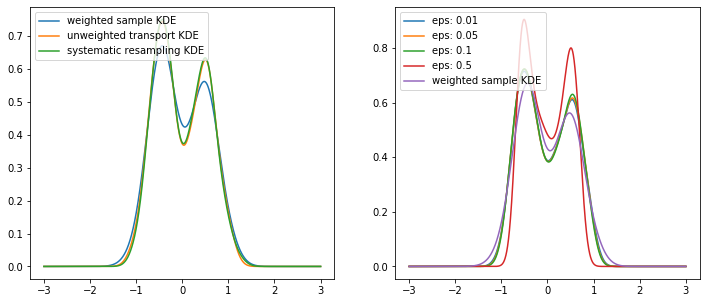

In [129]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

weighted_sample_kde = st.kde.gaussian_kde(X, weights=weights)
exact_transport_kde = st.kde.gaussian_kde((exactTransport.T * N) @ X)

systematic_index = systematic_resample(weights, randomState)
systematic_resampling_kde = st.kde.gaussian_kde(X[systematic_index])

_ = axes[0].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')
_ = axes[0].plot(linspace, exact_transport_kde(linspace), label='unweighted transport KDE')
_ = axes[0].plot(linspace, systematic_resampling_kde(linspace), label='systematic resampling KDE')

dataframeWeights = []

for eps, plan in zip(epsilons, approximateTransports):
    approx_transport_kde = st.kde.gaussian_kde(plan[0].detach().numpy().squeeze(), weights=plan[1].detach().numpy())
    dataframeWeights.append(pd.Series(data=plan[1].detach().numpy().squeeze(), name=eps))
    _ = axes[1].plot(linspace, approx_transport_kde(linspace), label=f'eps: {eps}')
    
_ = axes[1].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')


_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')

fig.savefig( 'DegenerateTransport.png')

In [130]:
def gradient_flow(loss, lr=.01) :
    """Flows along the gradient of the cost function, using a simple Euler scheme.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = .025):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = int(5/lr)+1
    display_its = [int(t/lr) for t in [0, .25, .50, 1., 2., 5.]]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12,8)) ; k = 1
    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g]  = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its : # display
            ax = plt.subplot(2,3,k) ; k = k+1

            display_samples(ax, y_j, (.55,.55,.95))
            display_samples(ax, x_i, (.95,.55,.55))

            ax.set_title("t = {:1.2f}".format(lr*i))
            plt.axis([-.1,1.1,-.1,5.5])
            plt.xticks([], []); plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title("t = {:1.2f}, elapsed time: {:.2f}s/it".format(lr*i, (time.time() - t_0)/Nsteps ))

In [131]:
unbiasedLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=eps)

In [149]:
epsilon = 0.1
loss = geomloss.SamplesLoss(debias=True, blur=epsilon)
var = torch_X.clone()
var.requires_grad = True

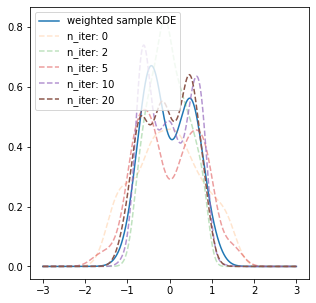

In [150]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

weighted_sample_kde = st.kde.gaussian_kde(X, weights=weights)
_ = ax.plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')

lr = 0.5
n_iter = 21
opt = torch.optim.Adam(lr = lr, params=[var])
for i in range(n_iter):
    
    opt.zero_grad()
    res = loss(torch_uniform_weights, var, torch_weights, torch_X)
    res.backward()
    opt.step()
    approx_transport_kde = st.kde.gaussian_kde(var.detach().numpy().squeeze(), weights=uniform_weights)
    if i in [0, 2, 5, 10, 20]:
        _ = ax.plot(linspace, approx_transport_kde(linspace), label=f'n_iter: {i}', alpha = min(1, 0.05 * i + 0.2), linestyle='--')
    
_ = ax.legend(loc='upper left')
fig.savefig('LearntDist.png')